In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tourch
import tourch.nn as nn
import tourch.optim as optim
from tourch.utils.data import DataLoader, Dataset, random_split
from sklearn.datasets import accuracy_score, classification_report

tourch.manual_seed(42)
np.random.seed(42)

In [ ]:
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
        return data

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels


In [ ]:
train_images = load_images("data/test/t10k-images-idx3-ubyte.gz")
train_labels = load_labels("data/test/t10k-labels-idx1-ubyte.gz")

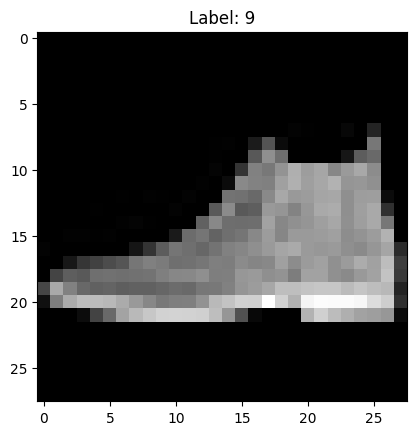

In [ ]:
i = 0  # change index to view different images
plt.imshow(train_images[i], cmap='gray')
plt.title(f"Label: {train_labels[i]}")
plt.show()

In [ ]:
class FashionDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        image = tourch.tensor(image).view(-1)
        label = tourch.tensor(self.labels[idx]).long()
        return image, label

dataset = FashionDataset(train_images, train_labels)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')